In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2025-10-17 10:46:47.289569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 10:46:47.915189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 10:46:50.583951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("STEP 2: Définition des paramètres")
IMAGE_DIR = 'Dataset/'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100  # L'entraînement sera stoppé avant si la performance stagne (EarlyStopping)
BEST_MODEL_PATH = 'best_model_unet.keras'


STEP 2: Définition des paramètres


In [4]:
print("STEP 3: Définition des fonctions de préparation des données")

def load_all_images(image_dir):
    """Charge toutes les images .jpg de manière récursive."""
    image_paths = glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True)
    clean_images = []
    for img_path in image_paths:
        try:
            img = load_img(img_path, target_size=IMG_SIZE, color_mode='rgb')
            img_array = img_to_array(img)
            clean_images.append(img_array)
        except Exception as e:
            print(f"Erreur de chargement pour {img_path}: {e}")
    return np.array(clean_images, dtype='float32') / 255.0


STEP 3: Définition des fonctions de préparation des données


In [5]:
def augment_and_add_noise(images_tensor, noise_range=(0.1, 0.3)):
    """Applique une augmentation (flip) et ajoute un bruit gaussien variable."""
    clean_augmented_images = []
    noisy_images = []

    for img in images_tensor:
        # 1. Augmentation (50% de chance d'un flip horizontal)
        augmented_img = img
        if tf.random.uniform(()) > 0.5:
            augmented_img = tf.image.flip_left_right(augmented_img)
        
        clean_augmented_images.append(augmented_img.numpy())

        # 2. Ajout de bruit variable
        noise_factor = tf.random.uniform((), minval=noise_range[0], maxval=noise_range[1])
        noise = tf.random.normal(shape=tf.shape(augmented_img))
        noisy_img_tensor = augmented_img + noise_factor * noise
        noisy_img_tensor = tf.clip_by_value(noisy_img_tensor, 0., 1.)
        noisy_images.append(noisy_img_tensor.numpy())

    return np.array(noisy_images), np.array(clean_augmented_images)


In [6]:
# CELL 4: Fonctions pour la construction du modèle
print("STEP 4: Définition de l'architecture du modèle U-Net")

def build_unet(input_shape):
    """Construit le modèle U-Net."""
    inputs = Input(input_shape)

    # Encodeur
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Décodeur avec skip connections
    u3 = UpSampling2D((2, 2))(b)
    u3 = concatenate([u3, c3])
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)

    u2 = UpSampling2D((2, 2))(d3)
    u2 = concatenate([u2, c2])
    d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d2)

    u1 = UpSampling2D((2, 2))(d2)
    u1 = concatenate([u1, c1])
    d1 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    d1 = Conv2D(32, (3, 3), activation='relu', padding='same')(d1)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def ssim_metric(y_true, y_pred):
    """Métrique SSIM pour l'évaluation."""
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


STEP 4: Définition de l'architecture du modèle U-Net


In [7]:
# CELL 5: Chargement des données
print("\nSTEP 5.1 - Chargement des images...")
clean_images = load_all_images(IMAGE_DIR)
print(f"    {len(clean_images)} images chargées.")



STEP 5.1 - Chargement des images...
    148 images chargées.


In [8]:
# CELL 6: Augmentation et création des données bruitées
print("  5.2 - Augmentation et ajout de bruit...")
x_full, y_full = augment_and_add_noise(tf.convert_to_tensor(clean_images))


  5.2 - Augmentation et ajout de bruit...


I0000 00:00:1760698107.169054  121400 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
# CELL 7: Division en jeux d'entraînement et de test
print("  5.3 - Division des données...")
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.2, random_state=42
)
print(f"    Taille de l'entraînement: {len(x_train)} images")
print(f"    Taille du test: {len(x_test)} images")


  5.3 - Division des données...
    Taille de l'entraînement: 118 images
    Taille du test: 30 images


In [10]:
# CELL 8: Construction et compilation du modèle
print("  5.4 - Construction et compilation du modèle U-Net...")
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
autoencoder_unet = build_unet(input_shape)
autoencoder_unet.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim_metric])
autoencoder_unet.summary()


  5.4 - Construction et compilation du modèle U-Net...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 1,946,947 (7.43 MB)

 Trainable params: 1,946,947 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# CELL 9: Définition des callbacks
print("  5.5 - Définition des callbacks...")
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1, monitor='val_loss'),
    ModelCheckpoint(BEST_MODEL_PATH, verbose=1, save_best_only=True, monitor='val_loss')
]

  5.5 - Définition des callbacks...


In [12]:
# CELL 10: Entraînement du modèle
print("  5.6 - Démarrage de l'entraînement...")
history = autoencoder_unet.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)



  5.6 - Démarrage de l'entraînement...
Epoch 1/100


2025-10-17 10:49:39.561176: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c396c0290c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-17 10:49:39.561221: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-10-17 10:49:39.699195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-17 10:49:39.956388: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-10-17 10:49:39.957454: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-10-17 10:49:39.957879: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-10-17 10:49:39.958304: W tensorflow/compiler/tf2xla/kernels/assert_o

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0833 - ssim_metric: 0.2222

2025-10-17 10:50:01.268559: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-10-17 10:50:01.269292: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-10-17 10:50:01.269883: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-10-17 10:50:01.270222: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-10-17 10:50:03.009517: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-17 10:50:12.755459: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0825 - ssim_metric: 0.2299   

2025-10-17 10:50:17.064696: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-10-17 10:50:17.065772: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-10-17 10:50:17.066318: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-10-17 10:50:17.066996: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-10-17 10:50:18.742438: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from None to 0.07031, saving model to best_model_unet.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.0801 - ssim_metric: 0.2529 - val_loss: 0.0703 - val_ssim_metric: 0.2633 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0759 - ssim_metric: 0.2640
Epoch 2: val_loss improved from 0.07031 to 0.06266, saving model to best_model_unet.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.0743 - ssim_metric: 0.2698 - val_loss: 0.0627 - val_ssim_metric: 0.2924 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0648 - ssim_metric: 0.3013
Epoch 3: val_loss improved from 0.06266 to 0.04903, saving model to best_model_unet.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.0617 - ssim_metric: 0.3028 - val_loss: 0.0490 - val_ssim_metric: 0.3426 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0487 - ssim_metric: 0.3493
Epoch 4: val_loss improved from 0.0

  5.8 - Évaluation finale sur le jeu de test avec le meilleur modèle...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


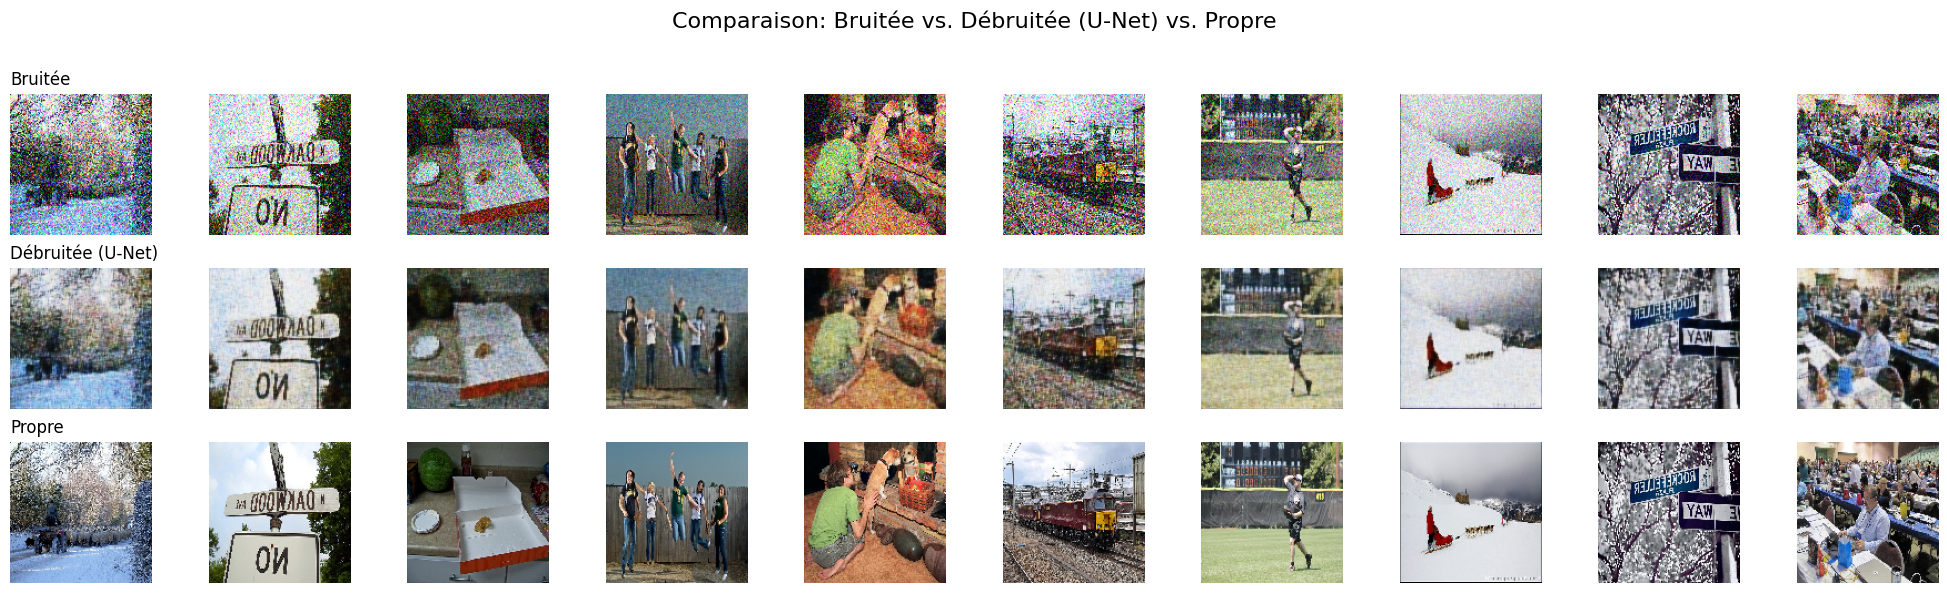


Pipeline terminé.


In [13]:
# CELL 12: Évaluation finale sur le jeu de test
print("  5.8 - Évaluation finale sur le jeu de test avec le meilleur modèle...")
best_model = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'ssim_metric': ssim_metric})
decoded_imgs = best_model.predict(x_test)
n = 10
plt.figure(figsize=(20, 6))
plt.suptitle('Comparaison: Bruitée vs. Débruitée (U-Net) vs. Propre', fontsize=16)
for i in range(min(n, len(x_test))):
    # Image bruitée (entrée)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.axis('off')
    if i == 0: plt.title('Bruitée', loc='left')

    # Image débruitée (sortie)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.axis('off')
    if i == 0: plt.title('Débruitée (U-Net)', loc='left')

    # Image propre (cible)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_test[i])
    ax.axis('off')
    if i == 0: plt.title('Propre', loc='left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nPipeline terminé.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
=== Résumé des métriques sur x_test ===
MSE: mean=0.0068, std=0.0034, min=0.0017, max=0.0153
MAE: mean=0.0602, std=0.0156, min=0.0329, max=0.0958
PSNR: mean=22.2623, std=2.2498, min=18.1530, max=27.5978
SSIM: mean=0.6395, std=0.0873, min=0.4477, max=0.8211

Exemples (10 premières) — PSNR / SSIM / MSE:
img 00: PSNR=18.15, SSIM=0.5806, MSE=0.015300
img 01: PSNR=20.66, SSIM=0.6849, MSE=0.008588
img 02: PSNR=23.30, SSIM=0.5289, MSE=0.004672
img 03: PSNR=24.45, SSIM=0.7121, MSE=0.003590
img 04: PSNR=21.10, SSIM=0.6113, MSE=0.007768
img 05: PSNR=18.53, SSIM=0.6136, MSE=0.014016
img 06: PSNR=22.90, SSIM=0.6858, MSE=0.005132
img 07: PSNR=22.27, SSIM=0.7055, MSE=0.005931
img 08: PSNR=18.29, SSIM=0.8211, MSE=0.014834
img 09: PSNR=19.77, SSIM=0.7394, MSE=0.010546


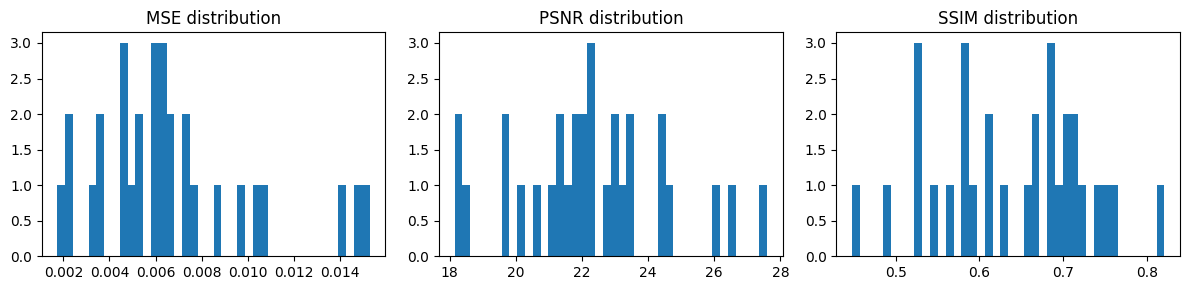

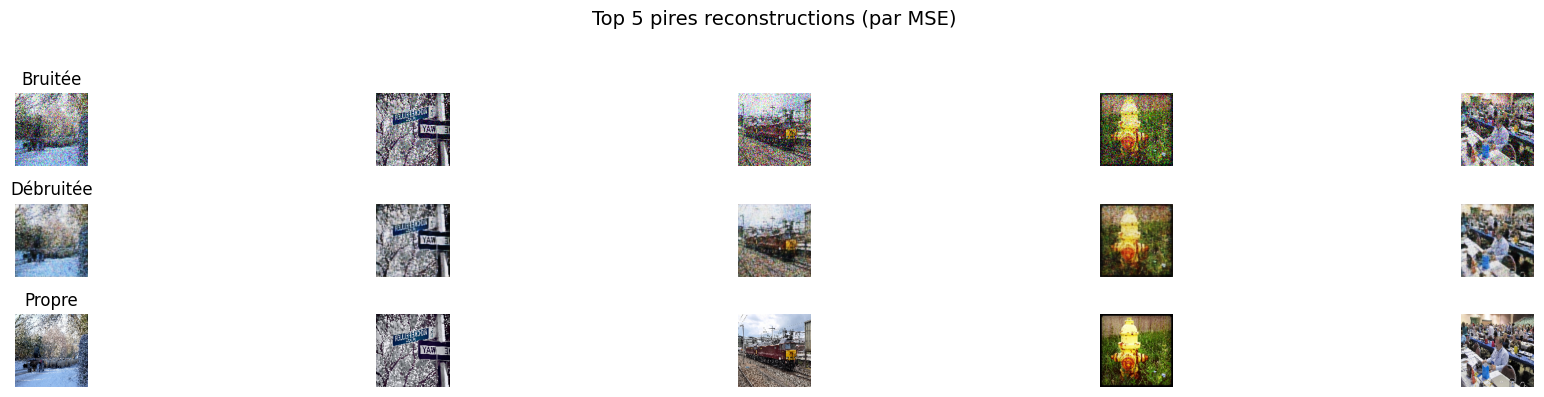

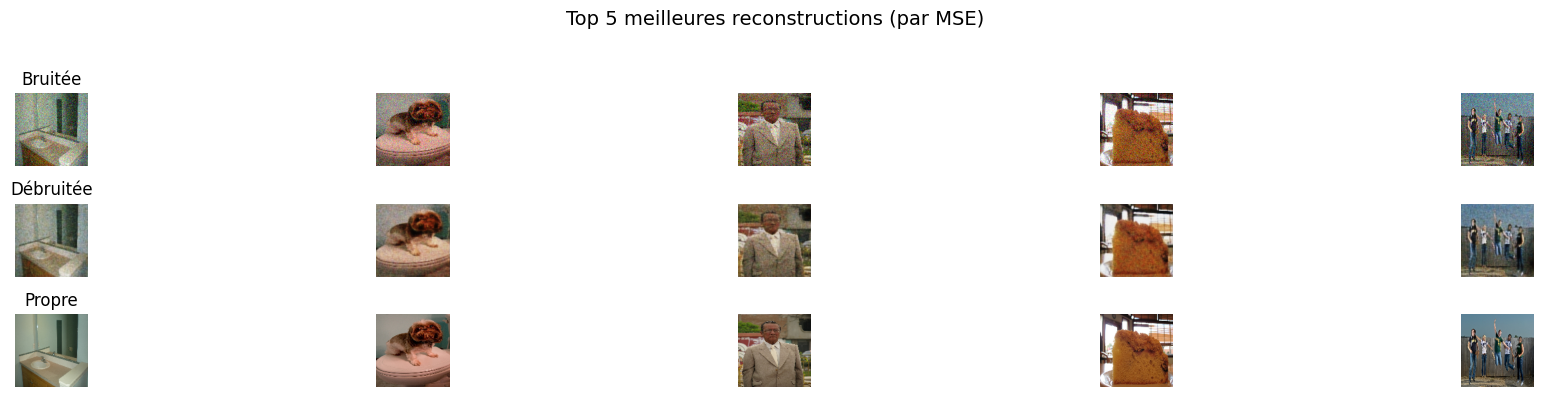

In [14]:
# Cell: Calcul et affichage des métriques du modèle U-Net (à exécuter après l'évaluation)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Vérifications rapides
if 'x_test' not in globals() or 'y_test' not in globals():
    print("x_test ou y_test introuvable. Exécutez la préparation des données (cells précédentes).")
else:
    # Charger le meilleur modèle si nécessaire
    try:
        best_model
    except NameError:
        try:
            best_model = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'ssim_metric': ssim_metric})
            print(f"Meilleur modèle chargé depuis {BEST_MODEL_PATH}")
        except Exception as e:
            print("Impossible de charger le meilleur modèle :", e)
            best_model = None

    # Prédictions
    if 'decoded_imgs' not in globals() or best_model is not None:
        if best_model is not None:
            decoded_imgs = best_model.predict(x_test)
        else:
            try:
                decoded_imgs = autoencoder_unet.predict(x_test)
            except Exception as e:
                print("Prédiction impossible :", e)
                decoded_imgs = None

    if decoded_imgs is None:
        print("Aucune prédiction disponible.")
    else:
        # Assurer plages et types
        y_true = np.clip(y_test, 0.0, 1.0).astype('float32')
        y_pred = np.clip(decoded_imgs, 0.0, 1.0).astype('float32')

        # Métriques par image
        mse_per_img = np.mean((y_true - y_pred) ** 2, axis=(1,2,3))
        mae_per_img = np.mean(np.abs(y_true - y_pred), axis=(1,2,3))
        psnr_vals = tf.image.psnr(y_true, y_pred, max_val=1.0).numpy()
        ssim_vals = tf.image.ssim(y_true, y_pred, max_val=1.0).numpy()

        def print_stat(name, arr):
            print(f"{name}: mean={arr.mean():.4f}, std={arr.std():.4f}, min={arr.min():.4f}, max={arr.max():.4f}")

        print("=== Résumé des métriques sur x_test ===")
        print_stat("MSE", mse_per_img)
        print_stat("MAE", mae_per_img)
        print_stat("PSNR", psnr_vals)
        print_stat("SSIM", ssim_vals)

        # Afficher quelques exemples (10 premiers)
        print("\nExemples (10 premières) — PSNR / SSIM / MSE:")
        for i in range(min(10, len(psnr_vals))):
            print(f"img {i:02d}: PSNR={psnr_vals[i]:.2f}, SSIM={ssim_vals[i]:.4f}, MSE={mse_per_img[i]:.6f}")

        # Histogrammes
        plt.figure(figsize=(12,3))
        plt.subplot(1,3,1); plt.hist(mse_per_img, bins=40); plt.title("MSE distribution")
        plt.subplot(1,3,2); plt.hist(psnr_vals, bins=40); plt.title("PSNR distribution")
        plt.subplot(1,3,3); plt.hist(ssim_vals, bins=40); plt.title("SSIM distribution")
        plt.tight_layout()
        plt.show()

        # Afficher les pires / meilleures reconstructions par MSE
        k = 5
        worst_idx = np.argsort(-mse_per_img)[:k]
        best_idx = np.argsort(mse_per_img)[:k]

        def show_list(idxs, title):
            n = len(idxs)
            plt.figure(figsize=(n*4, 4))
            plt.suptitle(title, fontsize=14)
            for j, idx in enumerate(idxs):
                # Bruitée / Prédite / Propre
                imgs = [x_test[idx], y_pred[idx], y_true[idx]]
                subtitles = ['Bruitée', 'Débruitée', 'Propre']
                for t, img in enumerate(imgs):
                    ax = plt.subplot(3, n, t*n + j + 1)
                    plt.imshow(img)
                    ax.axis('off')
                    if j == 0:
                        ax.set_title(subtitles[t])
            plt.tight_layout(rect=[0,0,1,0.95])
            plt.show()

        show_list(worst_idx, f"Top {k} pires reconstructions (par MSE)")
        show_list(best_idx, f"Top {k} meilleures reconstructions (par MSE)")


Meilleur modèle chargé depuis best_model_unet.keras
Débruitage avec le modèle sélectionné...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


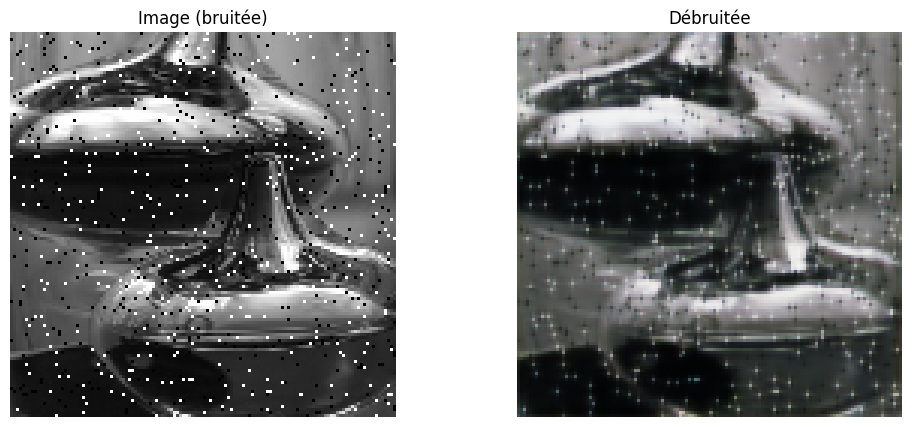

In [17]:
# Tester une image bruitée déjà téléchargée (corrigé)
LOCAL_PATH = "/root/livrable 2/Noise_salt_and_pepper.png"

if not os.path.exists(LOCAL_PATH):
    raise FileNotFoundError(f"Fichier introuvable: {LOCAL_PATH}")

# Charger, redimensionner et normaliser (load_img/img_to_array sont déjà importés)
img = load_img(LOCAL_PATH, target_size=IMG_SIZE, color_mode='rgb')
img_arr = img_to_array(img).astype('float32') / 255.0  # image déjà bruitée

# Préparer batch
noisy_batch = np.expand_dims(img_arr, 0)  # shape (1,H,W,3)

# Charger le meilleur modèle si possible, sinon utiliser le modèle en mémoire (autoencoder_unet)
model_to_use = None
try:
    model_to_use = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'ssim_metric': ssim_metric})
    print(f"Meilleur modèle chargé depuis {BEST_MODEL_PATH}")
except Exception:
    if 'autoencoder_unet' in globals():
        model_to_use = autoencoder_unet
        print("Aucun meilleur modèle trouvé sur le disque — utilisation de 'autoencoder_unet' en mémoire.")
    else:
        raise RuntimeError("Aucun modèle disponible pour la prédiction. Entraînez ou chargez un modèle d'abord.")

# Débruitage
print("Débruitage avec le modèle sélectionné...")
denoised_batch = model_to_use.predict(noisy_batch)
denoised_img = np.clip(denoised_batch[0], 0.0, 1.0)
noisy_img = np.clip(noisy_batch[0], 0.0, 1.0)

# Affichage côte à côte
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_img); plt.title("Image (bruitée)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(denoised_img); plt.title("Débruitée"); plt.axis('off')
plt.show()